In [4]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import galaxy_survey as gs
reload(gs)

<module 'galaxy_survey' from '/home/yanlong/Dropbox/galaxy_survey/galaxy_survey.cpython-38-x86_64-linux-gnu.so'>

In [5]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
#matplotlib.rcParams['font.serif'] = "Times New Roman"
#matplotlib.rcParams.update({'font.size': 10})

In [6]:
svy = gs.survey()

In [7]:
svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'reconstruction'], 
                        survey_geometrics={'f_sky': 0.5,'N_g': 1e100,'z_min': 0.1,'z_max': 0.2,'dz': 0.1,'Sigma_0': 16.6,'b_0': 0.95,'survey_type':'spectroscopic','sigma8_0': 0.9,})

In [12]:
def get_integrand_mat(svy, k, l, ddmax=4, coordinate='child18', ttmax=np.pi, z=0, mu1=0., mu2=0., unique=False, mu_opt=False, integrate_over_mu=False, div=101, k_max_bi=0.2):
    tiny = 1e-4
    if coordinate == 'child18':
        deltalst = y = np.linspace(tiny*svy.pisf, (ddmax-tiny)*svy.pisf, num=div)
        thetalst = x = np.linspace(np.pi*tiny, ttmax-np.pi*tiny, num=div)
    elif coordinate == 'cartesian':
        deltalst = y = np.linspace(0.01, 0.2, num=50)
        thetalst = x = np.linspace(0.01, 0.2, num=50)
    elif coordinate == 'ascending':
        deltalst = y = np.linspace(tiny*svy.pisf, (ddmax-tiny)*svy.pisf, num=20)
        thetalst = x = np.linspace(tiny*svy.pisf, (ddmax-tiny)*svy.pisf, num=20)
    dmat, tmat = np.meshgrid(deltalst, thetalst)
    #4extent = np.min(x), np.max(x), np.min(y), np.max(y)
    Amat = np.zeros(dmat.shape)
    # print(svy.alpha['value'], svy.beta['value'])
    
    for i in tqdm(range(len(deltalst))):
        for j in range(len(thetalst)):
            #Amat[i,j] = svy_m.bispectrum_derivative(kargs=(0.01, dmat[i,j], tmat[i,j]), coordinate='child18')[1]
            int2d = svy.integrand_2d([dmat[i,j], tmat[i,j], mu1, mu2], coordinate=coordinate, div_k1=191, z=z, k_max_bi=k_max_bi, unique=unique, mu_opt=mu_opt, integrate_over_mu=integrate_over_mu)
            Amat[i,j] = int2d[k,l]
            #print(i, j, dmat[i,j], tmat[i,j], Amat[i,j])
    return Amat

In [14]:
def draw_integration_peaks(Amat, coordinate, title, x_centers, y_centers, dxs, dys, 
                           savefig=False, k1_min=0.01, k1_max=0.2, normalize=True, debug=False):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.ticker import FuncFormatter, MultipleLocator
    import matplotlib.patches as patches
    f = plt.figure(figsize=(4, 4))
    ax = f.add_subplot(111)
    cmap = plt.get_cmap('Blues')
    if normalize:
        Amat /= np.sum(Amat)*(2*np.pi/3*4)/np.product(Amat.shape)
    if coordinate == 'child18':
        extent = 0, ttmax, 0, ddmax
        im = ax.imshow(Amat.T, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.ax.set_title(r'$I_2(\delta, \theta)$')

        delta = np.linspace(0, ddmax*svy.pisf)
        theta = np.arccos(-0.5/(1+delta/k1_min))
#         ax.plot(theta, delta/svy.pisf, c='w')
#         theta = np.arccos(-0.5/(1+delta/k1_max))
#         ax.plot(theta, delta/svy.pisf, 'w--')

        for i in range(3):
            x_center = x_centers[i]
            y_center = y_centers[i]
            dx = dxs[i]
            dy = dys[i]
            rect = patches.Rectangle((x_center-dx, y_center-dy),dx*2,dy*2,linewidth=1,edgecolor='k',facecolor='none')
            ax.add_patch(rect)

        ax.xaxis.set_major_formatter(FuncFormatter(
            lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'
        ))
        ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))

        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$\delta$')
        ax.set_ylim(0, ddmax)
        ax.annotate(title, (0.72, 0.8), xycoords='axes fraction')
        if savefig:
            plt.savefig('plots/integrand-contours.pdf', bbox_inches='tight')
            
        if debug:
            thetas = np.linspace(0, np.pi*2/3)
            k3 = 0.2
            for k1 in np.linspace(0.01, 0.2, num=20):
                b = 2*np.cos(thetas)*k1
                c = k1**2 - k3**2
                x = (-b +np.sqrt(b**2-4*c))/2 - k1
                x /= pisf
                ax.plot(thetas, x)
                ax.set_xlim(0, np.pi*2/3)
                ax.set_ylim(0, 4)
            
        plt.show()

    if coordinate == 'cartesian':
        extent = 0.01, 0.5, 0.01, 0.5
        im = ax.imshow(Amat, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(r'$I_2$')

        ax.set_xlabel(r'$k_2[h/{\rm Mpc}]$')
        ax.set_ylabel(r'$k_3[h/{\rm Mpc}]$')
        



    if coordinate == 'ascending':
        extent = 0, ddmax, 0, ddmax
        im = ax.imshow(Amat, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(r'$I_2$')

        ax.set_xlabel(r'$\delta_1$')
        ax.set_ylabel(r'$\delta_2$')
        plt.show()

In [15]:
def get_fractions(Amat, x_centers, y_centers, dxs, dys):
    x = np.linspace(0., ttmax, num=Amat.shape[1])
    y = np.linspace(0, ddmax, num=Amat.shape[0])
    x, y = np.meshgrid(x, y)
    xm = 0.4*np.pi
    crit = (x>2333)
    frac_area = 0.
    for i in range(3):
        x_center = x_centers[i]
        y_center = y_centers[i]
        dx = dxs[i]
        dy = dys[i]
        crit += ((x_center-dx<=x) & (x<x_center+dx) & (y_center-dy<y) & (y<y_center+dy))
        
        frac_area += 1/(ddmax*ttmax) * 2*dx * (min(ddmax, y_center+dy)-max(0., y_center-dy))
        # print(frac_area)
    frac_int = np.sum(Amat.T[crit])/np.sum(Amat)
    return frac_int, frac_area

In [16]:
ddmax = 4
ttmax = np.pi*2/3
coordinate='cartesian'
coordinate='child18'
# coordinate='ascending'
z = 0.15

dxs = np.array([0.2, 0.2, 0.2])*np.pi
dys = np.array([0.75, 0.5, 0.5])
x_centers = np.array([0.25, 0.25, 0.25])*np.pi
y_centers = [0, 1.85, 3.5]

In [17]:
import itertools
def get_ntris(x):
    k1 = x[:,0]
    k2 = x[:,0]+x[:,1]
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(x[:,2]))
    tris = (k2<=k3) & (k2<=0.2) & (k3<=0.2)
    return np.sum(tris)


def get_fraction_tri(x_centers, y_centers, dxs, dys):
    k1 = np.linspace(0.01, 0.2, num=100)
    delta = np.linspace(0, 4, num=100)
    theta = np.linspace(0, np.pi*2/3, num=100)
    x = np.array(list(itertools.product(k1, delta*pisf, theta)))
    
    crit_delta = delta < -100
    crit_theta = theta < -100
    for i in range(3):
        xc, yc = x_centers[i], y_centers[i]
        dx, dy = dxs[i], dys[i]
        crit_delta += (delta>=yc-dy) & (delta<=yc+dy)
        crit_theta += (theta>=xc-dx) & (theta<=xc+dx)
    delta = delta[crit_delta]
    theta = theta[crit_theta]
    
    #print(delta, theta/np.pi)
    y = np.array(list(itertools.product(k1, delta*pisf, theta)))
    return get_ntris(y)/get_ntris(x)

In [ ]:
Amat = get_integrand_mat(svy, -1, -1, ddmax=ddmax, ttmax=ttmax, coordinate='child18', unique=True, 
                         mu1=0.,
                         mu2=0.,
                         z=z,
                         div=41, 
                         integrate_over_mu=True
                        )
np.savetxt('integrand-contours.txt', Amat)

get_fraction_tri(x_centers, y_centers, dxs, dys)
get_fractions(Amat, x_centers, y_centers, dxs, dys)

In [145]:
Amat = np.loadtxt('integrand-contours.txt')

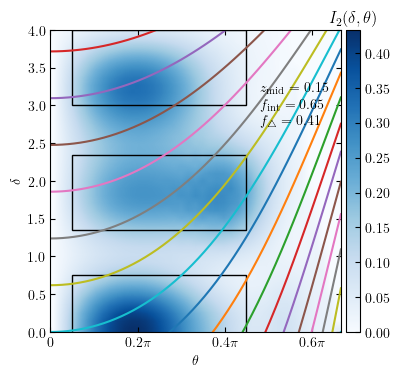

In [146]:
frac_int, frac_area = get_fractions(Amat, x_centers, y_centers, dxs, dys)
title = r'\ \\ $z_{\rm mid}=%.2f$\\ $f_{\rm int}=%.2f$\\ $f_{\rm \bigtriangleup}=%.2f$'%(z, frac_int, frac_area)
#title = r'$z_{\rm mid}=%.2f$, $f_{\rm int}=%.2f$'%(z, frac_int)
draw_integration_peaks(Amat, coordinate, title, x_centers, y_centers, dxs, dys, savefig=True, normalize=True, debug=True)

In [14]:
for z in [0, 1, 2, 3, 4]:
    Amat = get_integrand_mat(svy, 1,1, ddmax=ddmax, ttmax=ttmax, coordinate=coordinate, unique=True, 
                         mu1=1.,
                         mu2=0.,
                         z=z,
                         mu_opt=True,
                         div = 41,
                         integrate_over_mu=True
                        )
#     frac_int, frac_area = get_fractions(Amat, x_centers, y_centers, dxs, dys)
#     title = r'$z=%.3f$, $f_{\rm int}=%.3f$, $f_{\rm area}=%.3f$'%(z, frac_int, frac_area)
    draw_integration_peaks(Amat, coordinate, title, x_centers, y_centers, dxs, dys)

  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for z in [0.15]:
    Amat = get_integrand_mat(svy, -1,-1, ddmax=ddmax, ttmax=ttmax, coordinate=coordinate, unique=True, 
                         mu1=1.,
                         mu2=0.,
                         z=z,
                         mu_opt=True,
                         integrate_over_mu=False
                        )
    frac_int, frac_area = get_fractions(Amat, x_centers, y_centers, dxs, dys)
    title = r'$z=%.3f$, $f_{\rm int}=%.3f$, $f_{\rm area}=%.3f$'%(z, frac_int, frac_area)
    draw_integration_peaks(Amat, coordinate, title, x_centers, y_centers, dxs, dys)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
for z in [0.15]:
    Amat = get_integrand_mat(svy, -1,-1, ddmax=ddmax, ttmax=ttmax, coordinate=coordinate, unique=False, 
                         mu1=1.,
                         mu2=0.,
                         z=z,
                         mu_opt=True,
                         integrate_over_mu=False,
                         k_max_bi=2333
                        )
    frac_int, frac_area = get_fractions(Amat, x_centers, y_centers, dxs, dys)
    title = r'$z=%.3f$, $f_{\rm int}=%.3f$, $f_{\rm area}=%.3f$'%(z, frac_int, frac_area)
    draw_integration_peaks(Amat, coordinate, title, x_centers, y_centers, dxs, dys)

## plot partial vs. full integration comparison

In [66]:
survey_geo = {
    'f_sky': 0.5
}

In [75]:
ngs = [1e-1, 1e-5, 1e-3, 1e100]
ngs = [1e100]
zmids = np.linspace(0.15, 3.95, 39)
dz = 0.1

In [76]:
tiny = 1e-2

def set_region(cord='cartesian', mu_opt=True, bds=None, divs=None, dds=None):
    reg = {}
    reg['coordinate'] = cord
    reg['mu_opt'] = mu_opt
    reg['bounds'] = bds
    if divs!= None:
        reg['divideby'] = 'num'
        reg['divs'] = divs
    if dds!= None:
        reg['divideby'] = 'step'
        reg['dds'] = dds
    return reg

In [77]:
bounds_child_full = ((0.01, 0.2),
               (tiny*pisf, 4*pisf),
               (tiny*np.pi, np.pi),
               (0, 1),
               (0, np.pi*2))

i = 0
bounds_child_box1 = ((0.01, 0.2),
               (tiny*pisf, dys[i]*pisf),
               (x_centers[i]-dxs[i], x_centers[i]+dxs[i]),
               (0, 1),
               (0, np.pi*2))
i = 1
bounds_child_box2 = ((0.01, 0.2),
               ((y_centers[i]-dys[i])*pisf, (y_centers[i]+dys[i])*pisf),
               (x_centers[i]-dxs[i], x_centers[i]+dxs[i]),
               (0, 1),
               (0, np.pi*2))

i = 2
bounds_child_box3 = ((0.01, 0.2),
               ((y_centers[i]-dys[i])*pisf, (y_centers[i]+dys[i])*pisf),
               (x_centers[i]-dxs[i], x_centers[i]+dxs[i]),
               (0, 1),
               (0, np.pi*2))

In [78]:
dds = (0.019, 0.3*pisf, 0.005*np.pi, 0.1, 0.1*2*np.pi)

region_bs_21=set_region('child18', bds=bounds_child_full, dds = dds)

region_bs_2_p1=set_region('child18',bds=bounds_child_box1, dds=dds)
region_bs_2_p2=set_region('child18',bds=bounds_child_box2, dds=dds)
region_bs_2_p3=set_region('child18',bds=bounds_child_box3, dds=dds)

regions_bs_child = [region_bs_21]
regions_bs_child_partial = [region_bs_2_p1, region_bs_2_p2, region_bs_2_p3]
regions_bs_child_partial

[{'coordinate': 'child18',
  'mu_opt': True,
  'bounds': ((0.01, 0.2),
   (0.000322916768110126, 0.024218757608259447),
   (0.15707963267948966, 1.413716694115407),
   (0, 1),
   (0, 6.283185307179586)),
  'divideby': 'step',
  'dds': (0.019,
   0.009687503043303779,
   0.015707963267948967,
   0.1,
   0.6283185307179586)},
 {'coordinate': 'child18',
  'mu_opt': True,
  'bounds': ((0.01, 0.2),
   (0.043593763694867005, 0.0758854405058796),
   (0.15707963267948966, 1.413716694115407),
   (0, 1),
   (0, 6.283185307179586)),
  'divideby': 'step',
  'dds': (0.019,
   0.009687503043303779,
   0.015707963267948967,
   0.1,
   0.6283185307179586)},
 {'coordinate': 'child18',
  'mu_opt': True,
  'bounds': ((0.01, 0.2),
   (0.09687503043303779, 0.12916670724405038),
   (0.15707963267948966, 1.413716694115407),
   (0, 1),
   (0, 6.283185307179586)),
  'divideby': 'step',
  'dds': (0.019,
   0.009687503043303779,
   0.015707963267948967,
   0.1,
   0.6283185307179586)}]

In [79]:
regions_bs_child

[{'coordinate': 'child18',
  'mu_opt': True,
  'bounds': ((0.01, 0.2),
   (0.000322916768110126, 0.12916670724405038),
   (0.031415926535897934, 3.141592653589793),
   (0, 1),
   (0, 6.283185307179586)),
  'divideby': 'step',
  'dds': (0.019,
   0.009687503043303779,
   0.015707963267948967,
   0.1,
   0.6283185307179586)}]

In [80]:
regions = [regions_bs_child_partial, regions_bs_child_partial, regions_bs_child]
regions_label = ['child_partial_vary', 'child_partial', 'child', ]

In [81]:
import copy
def vary_partial_region(regs, z):
    regs_ = copy.deepcopy(regs)
    for reg in regs_:
        bounds = np.array(reg['bounds'])
        bounds[2][1] += (z-0.2)/3.8*0.15*np.pi
        bounds = tuple(map(tuple, bounds))
        reg['bounds'] = bounds
    return regs_

In [82]:
import h5py
def find_next_level(group, label):
    if label not in list(group.keys()):
        ng = group.create_group(label)
    else:
        ng = group[label]
    return ng

f = h5py.File("bispectrum_partial_vs_full.hdf5", "a")

In [83]:
di = 1
imax = 39//di
for r, label in zip(regions, regions_label):
    group_reg = find_next_level(f, label)
    print(label)
    for ng in ngs:
        ng_label = '%.e'%ng
        group_ng = find_next_level(group_reg, ng_label)
        print(ng_label)
        for i in tqdm(range(imax)):
            j = i*di
            zmax = zmids[j+di-1] + dz/2
            print('%.1f'%zmax, end=' ')
            zmax_label = '%.1f'%(zmax)
            group_zmax = find_next_level(group_ng, zmax_label)
            if 'fisher' in list(group_zmax.keys()):
                continue
            
            ng_z_list = np.transpose([zmids[j:j+di], np.repeat(ng, di), np.repeat(dz, di)])
            survey_geo['ng_z_list'] = ng_z_list
            sv = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ig_full, initial_params)
            if 'vary' in label:
                rt = vary_partial_region(r, zmax)
            else:
                rt = r
            print(rt[0]['bounds'][2], end=' ')
            fisher = sv.fisher_matrix_bs(rt, addprior=False, unique=True, k_max_bi=0.2, method='sobol')
            print('(%.1e)'%(fisher[1, 1]), end='\n')
            group_zmax.create_dataset("fisher", data=fisher)
            del sv
        print('')

f.close()

child_partial_vary
1e+100


  0%|          | 0/39 [00:00<?, ?it/s]

0.2 0.3 0.4 0.5 0.6 (0.15707963267948966, 1.463320788645772) (5.5e+00)
0.7 (0.15707963267948966, 1.4757218122783633) (6.9e+00)
0.8 (0.15707963267948966, 1.4881228359109546) (8.3e+00)
0.9 (0.15707963267948966, 1.500523859543546) (9.5e+00)
1.0 (0.15707963267948966, 1.5129248831761373) (1.1e+01)
1.1 (0.15707963267948966, 1.5253259068087286) (1.2e+01)
1.2 (0.15707963267948966, 1.5377269304413197) (1.3e+01)
1.3 (0.15707963267948966, 1.550127954073911) (1.4e+01)
1.4 (0.15707963267948966, 1.5625289777065023) (1.4e+01)
1.5 (0.15707963267948966, 1.5749300013390937) (1.5e+01)
1.6 (0.15707963267948966, 1.587331024971685) (1.6e+01)
1.7 (0.15707963267948966, 1.5997320486042763) (1.6e+01)
1.8 (0.15707963267948966, 1.6121330722368676) (1.7e+01)
1.9 (0.15707963267948966, 1.6245340958694587) (1.7e+01)
2.0 (0.15707963267948966, 1.63693511950205) (1.8e+01)
2.1 (0.15707963267948966, 1.6493361431346414) (1.8e+01)
2.2 (0.15707963267948966, 1.6617371667672327) (1.9e+01)
2.3 (0.15707963267948966, 1.6741381903

  0%|          | 0/39 [00:00<?, ?it/s]

0.2 (0.15707963267948966, 1.413716694115407) (6.5e-01)
0.3 (0.15707963267948966, 1.413716694115407) (1.6e+00)
0.4 (0.15707963267948966, 1.413716694115407) (2.8e+00)
0.5 (0.15707963267948966, 1.413716694115407) (4.1e+00)
0.6 (0.15707963267948966, 1.413716694115407) (5.4e+00)
0.7 (0.15707963267948966, 1.413716694115407) (6.7e+00)
0.8 (0.15707963267948966, 1.413716694115407) (7.9e+00)
0.9 (0.15707963267948966, 1.413716694115407) (9.1e+00)
1.0 (0.15707963267948966, 1.413716694115407) (1.0e+01)
1.1 (0.15707963267948966, 1.413716694115407) (1.1e+01)
1.2 (0.15707963267948966, 1.413716694115407) (1.2e+01)
1.3 (0.15707963267948966, 1.413716694115407) (1.3e+01)
1.4 (0.15707963267948966, 1.413716694115407) (1.3e+01)
1.5 (0.15707963267948966, 1.413716694115407) (1.4e+01)
1.6 (0.15707963267948966, 1.413716694115407) (1.4e+01)
1.7 (0.15707963267948966, 1.413716694115407) (1.5e+01)
1.8 (0.15707963267948966, 1.413716694115407) (1.5e+01)
1.9 (0.15707963267948966, 1.413716694115407) (1.5e+01)
2.0 (0.157

  0%|          | 0/39 [00:00<?, ?it/s]

0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.0 3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.0 


In [84]:
f.close()

In [85]:
dat = {}

with h5py.File("bispectrum_partial_vs_full.hdf5", "r") as f:
    for label in regions_label:
        coord = f[label]
        print(label)
        temp_coord = {}
        for ng_label in list(coord.keys()):
            ng = coord[ng_label]
            zs = []
            f22s = []
            for z in list(ng.keys()):
                zs.append(float(z)-dz/2)
                f22s.append(ng[z]['fisher'][1,1])
            # f22s = np.cumsum(f22s)
            temp = np.transpose([zs, f22s])
            temp_coord[ng_label] = temp
        dat[label] = temp_coord
        

child_partial_vary
child_partial
child


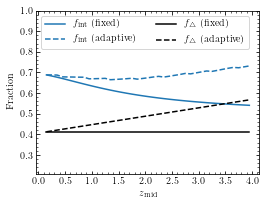

In [150]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(4, 3))

for ng in list(dat['child'].keys())[::-1]:
    if float(ng) < 1e5:
        continue
    if float(ng)>1e5:
        label=r'$f_{\rm int}$ ('
    else:
        label=r'$\bar{n}_{\rm g} = 10^{%d}\,(h\,{\rm Mpc}^{-1})^{3}$'%(np.log10(float(ng)))
    zs = dat['child'][ng][:,0]
    ratio = dat['child_partial'][ng][:,1]/dat['child'][ng][:,1]
    p = ax.plot(zs, ratio, label=label+'fixed)')
    ratio = dat['child_partial_vary'][ng][:,1]/dat['child'][ng][:,1]
    c = p[0].get_color()
    ax.plot(zs, ratio, c=c, linestyle='--', label=label+'adaptive)')
    

ax.plot(zmids, np.repeat(frac_area, zmids.shape[0]), 'k', label=r'$f_{\bigtriangleup}$ (fixed)')
ax.plot(zmids, frac_area*(1+(zmids+dz/2-0.2)/3.8*0.15/0.4), 'k--', label=r'$f_{\bigtriangleup}$ (adaptive)')
    
    
ax.legend(ncol=2, loc='upper left')
ax.set_xlabel(r'$z_{\rm mid}$')
ax.set_ylabel(r'Fraction')
ax.set_ylim(0.21, 1)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))

plt.savefig('full_vs_partial_information.pdf', bbox_inches='tight')

## integrand as a function of mu

  0%|          | 0/20 [00:00<?, ?it/s]

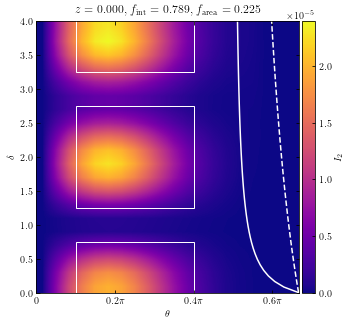

  0%|          | 0/20 [00:00<?, ?it/s]

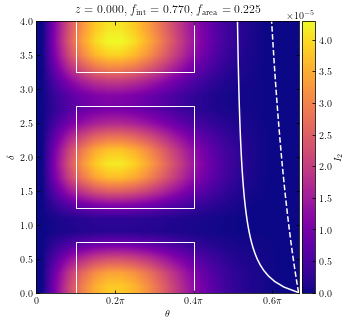

  0%|          | 0/20 [00:00<?, ?it/s]

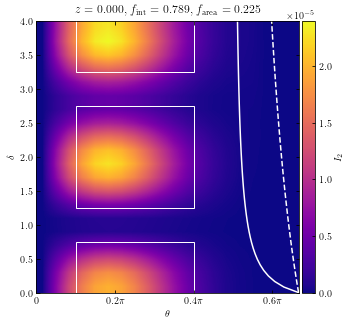

  0%|          | 0/20 [00:00<?, ?it/s]

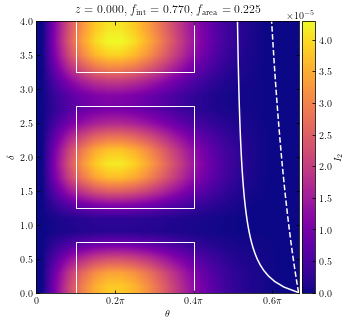

  0%|          | 0/20 [00:00<?, ?it/s]

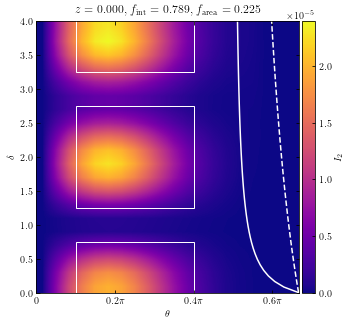

In [252]:
for mu2 in np.linspace(0, 2*np.pi, num=5):
    Amat = get_integrand_mat(svy, 1,1, ddmax=ddmax, ttmax=ttmax, coordinate=coordinate, unique=True, 
                         mu1=0.5,
                         mu2=mu2,
                         mu_opt=True,
                         z=0.,
                         integrate_over_mu=False
                        )
    frac_int = get_fractions(Amat, x_center, y_centers, dx, dy)
    title = r'$z=%.3f$, $f_{\rm int}=%.3f$, $f_{\rm area}=%.3f$'%(z, frac_int, frac_area)
    draw_integration_peaks(Amat, coordinate, title)

In [16]:
tiny = 1e-2


def set_region(cord='cartesian', mu_opt=True, bds=None, divs=None, dds=None):
    reg = {}
    reg['coordinate'] = cord
    reg['mu_opt'] = mu_opt
    reg['bounds'] = bds
    if divs!= None:
        reg['divideby'] = 'num'
        reg['divs'] = divs
    if dds!= None:
        reg['divideby'] = 'step'
        reg['dds'] = dds
    return reg

In [17]:
dx = 0.15*np.pi
dy = 0.75
x_center = 0.25*np.pi
y_centers = [0, 2, 4]

bounds_child_full = ((0.01, 0.2),
               (tiny*pisf, 4*pisf),
               (tiny*np.pi, np.pi),
               (0, 1),
               (0, np.pi*2))

bounds_child_half = ((0.01, 0.2),
               (tiny*pisf, 4*pisf),
               (tiny*np.pi, np.pi/2),
               (0, 1),
               (0, np.pi*2))

bounds_child_box1 = ((0.01, 0.2),
               (tiny*pisf, dy*pisf),
               (x_center-dx, x_center+dx),
               (0, 1),
               (0, np.pi*2))

bounds_child_box2 = ((0.01, 0.2),
               ((2-dy)*pisf, (2+dy)*pisf),
               (x_center-dx, x_center+dx),
               (0, 1),
               (0, np.pi*2))

bounds_child_box3 = ((0.01, 0.2),
               ((4-dy)*pisf, 4*pisf),
               (x_center-dx, x_center+dx),
               (0, 1),
               (0, np.pi*2))

In [18]:
dds = (0.01, 0.2*pisf, 0.05*np.pi, 0.1, 0.1*2*np.pi)

region_bs_21=set_region('child18', bds=bounds_child_full, dds = dds)

region_bs_22=set_region('child18',bds=bounds_child_half, dds=dds)

region_bs_2_p1=set_region('child18',bds=bounds_child_box1, dds=dds)
region_bs_2_p2=set_region('child18',bds=bounds_child_box2, dds=dds)
region_bs_2_p3=set_region('child18',bds=bounds_child_box3, dds=dds)

regions_bs_child = [region_bs_21]
regions_bs_child_left = [region_bs_22]
regions_bs_child_partial = [region_bs_2_p1, region_bs_2_p2, region_bs_2_p3]

In [19]:
fisher_all = svy.fisher_matrix_bs(regions_bs_child, addprior=False, unique=True, k_max_bi=0.2, method='sobol')

In [20]:
fisher_part = svy.fisher_matrix_bs(regions_bs_child_partial, addprior=False, unique=True, k_max_bi=0.2, method='sobol')

In [23]:
fisher_part[1,1]/fisher_all[1,1]

0.7049872299495797

In [24]:
frac_area = dx*dy*4*2/(ddmax*ttmax)
frac_area

0.3375

In [26]:
fisher_all[1,1]

0.9447836981532839

In [33]:
# coordinate = 'child18'
#coordinate = ''
def get_Amat(svy):
    tiny = 1e-3
    deltalst = y = np.linspace(tiny*svy.pisf, (4-tiny)*svy.pisf, num=50)
    thetalst = x = np.linspace(np.pi*tiny, np.pi*(1-tiny), num=50)
    dmat, tmat = np.meshgrid(deltalst, thetalst)
    #4extent = np.min(x), np.max(x), np.min(y), np.max(y)
    Amat = np.zeros(dmat.shape)
    print(svy.alpha_prior, svy.beta_prior)
    for i in range(len(deltalst)):
        for j in range(len(thetalst)):
            Amat[i,j] = svy.A_bi(dmat[i,j], tmat[i,j], k1_min=0.01, div_k1=10000)*np.sqrt(0.2-0.01)
    return Amat

Amat = get_Amat(svy)

{'mean': 1.0, 'stdev': 0.008240659793814433} {'mean': 1.0, 'stdev': 1e+100}


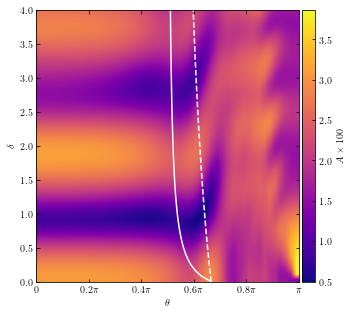

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, MultipleLocator
f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
cmap = plt.get_cmap('plasma')
extent = 0, np.pi, 0, 4
ddmax=4
im = ax.imshow(Amat.T*100, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label(r'$A\times 100$')

ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))

delta = np.linspace(0, ddmax*svy.pisf)
k1_min, k1_max = 0.01, 0.2
theta = np.arccos(-0.5/(1+delta/k1_min))
ax.plot(theta, delta/svy.pisf, c='w')
theta = np.arccos(-0.5/(1+delta/k1_max))
ax.plot(theta, delta/svy.pisf, 'w--')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\delta$')
#plt.savefig('bi_inter.pdf', bbox_inches='tight')
plt.show()

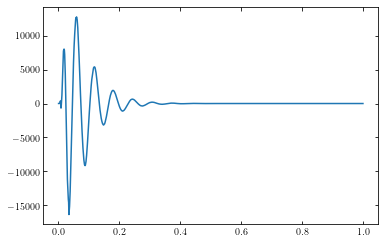

In [27]:
k = np.linspace(0.001, 1, num=1000)
db = np.array([svy.bispectrum_derivative((x,1,1)) for x in k])
plt.plot(k, db[:,1])

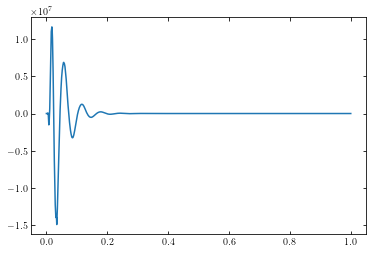

In [28]:
k = np.linspace(0.001, 1, num=1000)
db = np.array([svy.bispectrum_derivative((x,0,0.7), coordinate='child18') for x in k])
plt.plot(k, db[:,1])

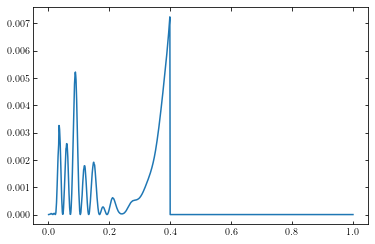

In [29]:
k = np.linspace(0.001, 1.001, num=1000)
db = np.array([svy.integrand_bs((x,0.2,0.2,0,0,),0, unique=False) for x in k])
plt.plot(k, db[:,1][:,1])

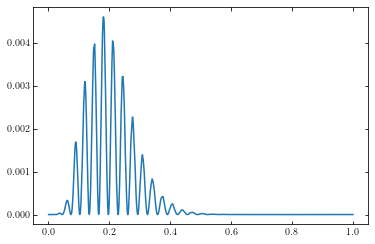

In [30]:
k = np.linspace(0.001, 1.001, num=1000)
db = np.array([svy.integrand_bs((x,0,0.5,0,0,),0, coordinate='child18') for x in k])
plt.plot(k, db[:,1][:,1])

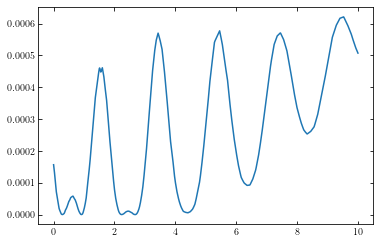

In [31]:
dd = np.linspace(0.001, 10, num=1000)
db = np.array([svy.integrand_bs((0.1,x*svy.pisf,np.pi/2,0,0,),0, coordinate='child18') for x in dd])
plt.plot(dd, db[:,1][:,1])

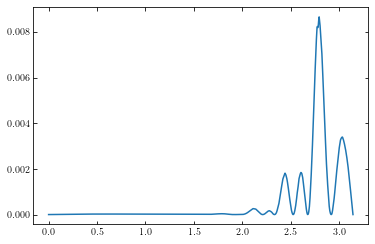

In [32]:
dd = np.linspace(0.001, np.pi, num=1000)
db = np.array([svy.integrand_bs((0.2,0.12,x,0,0,),0, coordinate='child18') for x in dd])
plt.plot(dd, db[:,1][:,1])

In [33]:
def get_integrand_k1_mat(svy, k1):
    tiny = 1e-4
    deltalst = y = np.linspace(tiny*svy.pisf, (4-tiny)*svy.pisf, num=50)
    thetalst = x = np.linspace(np.pi*tiny, np.pi*(1-tiny), num=50)
    dmat, tmat = np.meshgrid(deltalst, thetalst)
    #4extent = np.min(x), np.max(x), np.min(y), np.max(y)
    Amat = np.zeros(dmat.shape)
    print(svy.alpha_prior, svy.beta_prior)
    for i in range(len(deltalst)):
        for j in range(len(thetalst)):
            Amat[i,j] = svy.integrand_bs((k1 ,dmat[i,j], tmat[i,j], 0,0,), 0, coordinate='child18')[1,1]
    return Amat

Amat = get_integrand_k1_mat(svy, 0.2)

{'mean': 1.0, 'stdev': 0.008240659793814433} {'mean': 1.0, 'stdev': 1e+100}


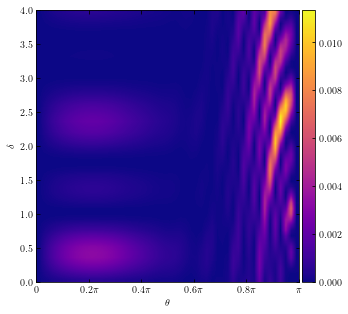

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, MultipleLocator
f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
cmap = plt.get_cmap('plasma')
extent = 0, np.pi, 0, 4
ddmax=4
im = ax.imshow(Amat.T, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
# cb.set_label(r'$A\times 100$')

ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))

# delta = np.linspace(0, ddmax*svy.pisf)
# k1_min, k1_max = 0.01, 0.2
# theta = np.arccos(-0.5/(1+delta/k1_min))
# ax.plot(theta, delta/svy.pisf, c='w')
# theta = np.arccos(-0.5/(1+delta/k1_max))
# ax.plot(theta, delta/svy.pisf, 'w--')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\delta$')
plt.show()